# Libraries and setup variables

In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score

from utils import *

%matplotlib inline
sns.set()

### Loading the processed dataset

Here we'll load the data into a dataframe, and run a series of initial exploratory analysis.

In [2]:
df_train = pd.read_csv('../data/processed/census_income_learn.csv')
df_test  = pd.read_csv('../data/processed/census_income_test.csv')

In [3]:
# columns_types
cont_columns, nominal_columns = columns_types()

df = df_train.copy()
df = one_hot_df(df, ['set'])

### Initial exploration of features importance

We can run a random forest classifier to rank features importance, this should give us an initial first pass.

This model suggests that features such as age or dividends are important in a model. In order to not make the model too complex to start with,
we could take the first 10 features first.

In [4]:
# Import `RandomForestClassifier`
from sklearn.ensemble import RandomForestClassifier

# Isolate Data, class labels and column values
X = df.iloc[:,0:40]
Y = df.iloc[:,-2]
names = df.columns.values

# Build the model
rfc = RandomForestClassifier()

# Fit the model
rfc.fit(X, Y)

# Print the results
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.12, 'age'), (0.096600000000000005, 'dividends from stocks'), (0.086900000000000005, 'capital gains'), (0.079299999999999995, 'education'), (0.071300000000000002, 'detailed occupation recode'), (0.058500000000000003, 'detailed industry recode'), (0.051299999999999998, 'major occupation code'), (0.044499999999999998, 'major industry code'), (0.042200000000000001, 'num persons worked for employer'), (0.038199999999999998, 'weeks worked in year'), (0.030599999999999999, 'class of worker'), (0.029899999999999999, 'sex'), (0.027400000000000001, 'capital losses'), (0.0177, 'tax filer stat'), (0.017600000000000001, 'detailed household and family stat'), (0.017500000000000002, 'own business or self employed'), (0.0146, 'detailed household summary in household'), (0.0141, 'marital stat'), (0.014, 'country of birth father'), (0.0137, 'wage per hour'), (0.013599999999999999, 'full or part time employment stat'), (0.012999999999999999, 'country of birth mother'),

### 1) Decision Tree
Decision tree, achieving a 94.8% accuracy on both sets. This is better than just predicting everyone does less than 50K, which would be 93% as established in the feature exploration part. At the same time, we should use more advanced measures of accuracy due to the present class inbalance in our population.

In [5]:
important_columns = ['age', 'dividends from stocks', 'capital gains', 'education', 'detailed industry recode', 'detailed occupation recode',
                     'major occupation code', 'major industry code', 'weeks worked in year', 'num persons worked for employer', 'class of worker',
                     'sex']

X_train = df_train[important_columns]
X_train = one_hot_df(X_train)
X_test  = df_test[important_columns]
X_test  = one_hot_df(X_test)
Y_train = df_train['salary'].values
Y_test  = df_test['salary'].values

clf = tree.DecisionTreeClassifier(max_depth=7)
clf.fit(X_train, Y_train)

Y_train_pred  = clf.predict(X_train)
Y_test_pred  = clf.predict(X_test)

print('Training accuracy: {} %'.format(accuracy_score(Y_train, Y_train_pred)))
print('Test accuracy: {} %'.format(accuracy_score(Y_test, Y_test_pred)))

/Users/lievgarcia/Sites/us_census/notebooks/utils.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[column] = labels


Training accuracy: 0.9503415646316464 %
Test accuracy: 0.9485074477255869 %


#### Overfitting

We can create a few trees with different depths, and we can observe that when the depth exceeds 7, we start overfitting and our

test set accuracy decreases badly.

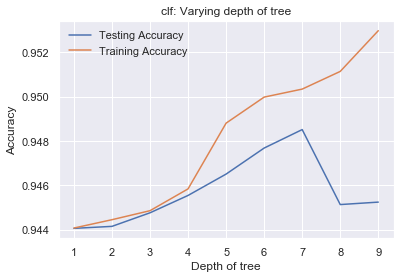

In [6]:
dep = np.arange(1, 10)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

for i, k in enumerate(dep):
    
    clf = tree.DecisionTreeClassifier(max_depth=k)
    clf.fit(X_train, Y_train)

    #Compute accuracies
    train_accuracy[i] = clf.score(X_train, Y_train)
    test_accuracy[i] = clf.score(X_test, Y_test)

plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

We can see the report for a RF of depth 7, from the confusion matrix we can also see the inbalance in classes and how is affecting the accuracy

In [31]:
class_report(Y_test, Y_test_pred,'training')

training Set:

training Confusion Matrix:
[[93131   445]
 [ 4692  1494]]
training Classification report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97     93576
          1       0.77      0.24      0.37      6186

avg / total       0.94      0.95      0.94     99762

training Accuracy: 0.9485074477255869


### 2) Logistic Regression

In the case of the Logistic regression we'll:

1 - run a simple fit, generate a summary
2 - Compute the ROC curve, showing that a tradeoff will need to be made between False positives and False Negatives
3 - Try a fit with a 'balancing' of the classes
4 - Grid search for a good hyperparameter.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

# Predict the labels of the test set: y_pred
Y_pred = logreg.predict(X_test)

class_report(Y_test, Y_pred,'training')

training Set:

training Confusion Matrix:
[[92802   774]
 [ 4877  1309]]
training Classification report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97     93576
          1       0.63      0.21      0.32      6186

avg / total       0.93      0.94      0.93     99762

training Accuracy: 0.9433551853411118


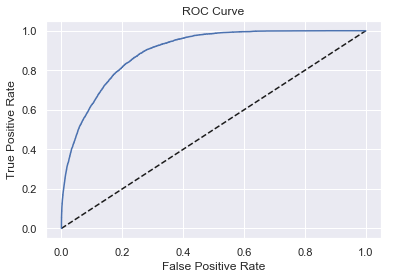

In [33]:
# Compute predicted probabilities: y_pred_prob
Y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [34]:
# Running a balanced classes fit
logreg = LogisticRegression(random_state=0, class_weight='balanced')
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
class_report(Y_test, Y_pred,'training')

# We can see that the overall accuracy drops, but the accuracy of the smaller class improves

training Set:

training Confusion Matrix:
[[73357 20219]
 [  954  5232]]
training Classification report:
             precision    recall  f1-score   support

          0       0.99      0.78      0.87     93576
          1       0.21      0.85      0.33      6186

avg / total       0.94      0.79      0.84     99762

training Accuracy: 0.7877648804153886


#### Grid Search
We can also grid search for optimal hyper parameters.

In [41]:
# Grid search of optimal hyperparameters for Logistic Regression
c_space = np.logspace(-10, 10, 20)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# logreg = LogisticRegression(random_state=0, class_weight='balanced')
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X_train, Y_train)

# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

# Test the model on the test set
Y_pred = logreg_cv.predict(X_test)
class_report(Y_test, Y_pred,'training')

Tuned Logistic Regression Parameters: {'C': 0.026366508987303555, 'penalty': 'l2'}
Best score is 0.9465525277787523
training Set:

training Confusion Matrix:
[[92992   584]
 [ 4996  1190]]
training Classification report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97     93576
          1       0.67      0.19      0.30      6186

avg / total       0.93      0.94      0.93     99762

training Accuracy: 0.9440668791724304
